<h1>Data Science and Analytics
<h3>Sentiment Analysis

<h4>Name: Ugwu Samuel Chidiebere


In [1]:
import pandas as pd
import numpy as np
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from re import search
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings


<h2>1 Data Cleaning

In [2]:
sentiment_analysis_df = pd.read_csv('Downloads/sentiment_analysis.csv')
sentiment_analysis_df

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1
...,...,...,...
550386,8.046170e+17,@goddesses_o I can't stop watching her...mm. M...,0
550387,8.046180e+17,Poor old Tom Odell doesn't look like he would ...,0
550388,8.046180e+17,#antsmasher I smashed 7 ants in this awesome ...,1
550389,8.046180e+17,@LizHudston @KymWyllie @Evasmiless @meanBok @l...,1


In [3]:
Canadian_Elections_df = pd.read_csv('Downloads/Canadian_elections_2021.csv')
Canadian_Elections_df

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN
...,...,...,...
997,This is absolutely horrible in Canada. The for...,negative,others
998,@davidakin Trudeau imposes gun control policie...,negative,gun control
999,In Canada 🇨🇦 our election is being stolen by t...,negative,others
1000,"O'Toole amends platform on gun control, but qu...",negative,tell lies


In [4]:
Canadian_Elections_df.describe()

,text,sentiment,negative_reason
count,1002,1002,387
unique,1002,2,11
top,The Canadian election is a power grab by PM Tr...,positive,others
freq,1,615,149


In [5]:
Canadian_Elections_df['text'][11]

"Who wanted this election again? Erin O'Toole? Jagmeet Singh? Canadians? Who triggered it on Aug. 15, 3 days after the Public Health Agency of Canada said we were in the 4th wave of the pandemic? Who hasn't given a coherent reason for why he called it? Thinking .. thinking ... 🤔"

In [6]:
sentiment_analysis_df['text'][11]

'Happy birthday to the most handsome kid in the world, love u like the son I never had congrats on the L @Snavitsky7 https://t.co/wGGb6sXTUt'

In [7]:
# List Sentiment
sentiment_unique_values = Canadian_Elections_df.sentiment.unique()
print(sentiment_unique_values)

['negative' 'positive']


In [8]:
# Encode for sentiment
encode_sentiment = {
    'negative': 0,
    'positive': 1,
}
Canadian_Elections_df['sentiment'] = Canadian_Elections_df.sentiment.map(encode_sentiment)

In [9]:
Canadian_Elections_df

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,0,calling election early
1,I do hope Trudeau loses the Canadian election ...,0,covid
2,"Dear Canadians, This election is a test of how...",1,NaN
3,Canadian friends: Never forget that Trudeau ha...,0,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,1,NaN
...,...,...,...
997,This is absolutely horrible in Canada. The for...,0,others
998,@davidakin Trudeau imposes gun control policie...,0,gun control
999,In Canada 🇨🇦 our election is being stolen by t...,0,others
1000,"O'Toole amends platform on gun control, but qu...",0,tell lies



<h3>1.1 Remove all html tags and attributes (i.e., /<[^>]+>/)

In [10]:
# Using a regex, compile the regex pattern and match them into original text
def remove_html(text):
    html_remove = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    cleantext = re.sub(html_remove, '', text)
    return cleantext

In [11]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(remove_html)

In [12]:
Canadian_Elections_df['text'] = Canadian_Elections_df['text'].apply(remove_html)

<h3>1.2 Html character codes (i.e., &...;) are replaced with an ASCII equivalent

In [13]:
# Normal form form for the Unicode string
# NFKD will apply the compatibility decomposition, i.e. replace all compatibility characters with their equivalents
# Encode create creates a byte string, which cannot be mixed with a regular string
# Decode can convert back to string again
def ASCII_equivalent(text):
    ASCII_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return ASCII_text

In [14]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(ASCII_equivalent)

In [15]:
Canadian_Elections_df['text'] = Canadian_Elections_df['text'].apply(ASCII_equivalent)

<h3>1.3 Remove all URLs

In [16]:
def remove_URL(text):
    cleantext = re.sub(r'http\S+', '', text)
    return cleantext

In [17]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(remove_URL)

In [18]:
Canadian_Elections_df['text'] = Canadian_Elections_df['text'].apply(remove_URL)

In [19]:
Canadian_Elections_df['text'][11]

"Who wanted this election again? Erin O'Toole? Jagmeet Singh? Canadians? Who triggered it on Aug. 15, 3 days after the Public Health Agency of Canada said we were in the 4th wave of the pandemic? Who hasn't given a coherent reason for why he called it? Thinking .. thinking ... "

In [20]:
sentiment_analysis_df['text'][11]


'Happy birthday to the most handsome kid in the world, love u like the son I never had congrats on the L @Snavitsky7 '

<h3>1.4 All characters in the text are in lowercase

In [21]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].str.lower()

In [22]:
Canadian_Elections_df['text'] = Canadian_Elections_df['text'].str.lower()


<h3>1.5 Remove all stop words

In [24]:
# Remove symbols in the words
def remove_non_letter(x):
    clean_text = re.sub(r'[^a-zA-Z ]+', ' ', x)
    return clean_text
#     return [re.sub(r'[^a-zA-Z ]+', ' ', str(x))]

In [25]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(remove_non_letter)

In [26]:
Canadian_Elections_df['text'] = Canadian_Elections_df['text'].apply(remove_non_letter)


Returning all words to the base of such word, this would help in removing the stop words.

In [27]:
# Remove inflectional endings and to return the base of a word (eg :s, ing)
nltk.download('wordnet')
def lemmatization(x):
    lemmatizer = nltk.WordNetLemmatizer()
    words_v = [lemmatizer.lemmatize(w, pos='v') for w in x.split()]
    words_n = [lemmatizer.lemmatize(w, pos='n') for w in words_v]
    return [lemmatizer.lemmatize(w, pos=('a')) for w in words_n]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/samuelugwu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [28]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(lemmatization)

In [35]:
Canadian_Elections_df['text'] = Canadian_Elections_df['text'].apply(lemmatization)

In [33]:
# Remove stop words from dataframe
nltk.download('stopwords')
stop_word = set(stopwords.words("english"))

def remove_stopword(x):
    return [word for word in x if word not in stop_word]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelugwu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
sentiment_analysis_df['text'] = sentiment_analysis_df['text'].apply(remove_stopword)

In [36]:
Canadian_Elections_df['text'] = Canadian_Elections_df['text'].apply(remove_stopword)


Example of clean tweet after carrying out the data cleaning process

In [37]:
Canadian_Elections_df['text'][11]

['want',
 'election',
 'erin',
 'toole',
 'jagmeet',
 'singh',
 'canadian',
 'trigger',
 'aug',
 'day',
 'public',
 'health',
 'agency',
 'canada',
 'say',
 'th',
 'wave',
 'pandemic',
 'give',
 'coherent',
 'reason',
 'call',
 'think',
 'think']

<h2>2 Exploratory analysis
<h3>2.1 Determines the political party from tweet

In order to classify the political parties I used a simple procedure which is more akin to the bag of Words Technique. I identified keywords associated with each political parties, the obvious ones include the candidates the party name and nicknames. 

Any tweet which contains more of a certain political party keyword is classified as a tweet affliated with such party. The drawback would be we may have tweets where the keywords are equal and they would fall in the category of others.

Political Party in Canada include:

1.liberal Party: 
2.Conservative  Party: 

3.ND Party: 
4.PPC:

5.Others

In [161]:
# Keyword for Parties
liberal = ['lpc', 'trudeau', 'justin', 'liberal']
conservative = ['cpc', 'erin', 'toole', 'otoole','tories','conservative']
ndp = ['ndp', 'democrats', 'jagmeet', 'singh']
ppc = ['barrie', 'maxime', 'bernier', 'ppc','purplewave']
Canadian_Elections_df['party'] = 'NaN'
liberal_list = []
conservative_list = []
ppc_list = []
ndp_list = []
liberal_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
conservative_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
ppc_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
ndp_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])
other_df = pd.DataFrame(None, columns=['text', 'sentiment', 'negative_reason'])

for i in range(Canadian_Elections_df.shape[0]):
    election_list = Canadian_Elections_df['text'][i]

    liberal_list = []
    conservative_list = []
    ppc_list = []
    ndp_list = []
    
    
    for l in liberal:
        for s in election_list:
            if l in s:
                liberal_list.append(s)
    for c in conservative:
        for s in election_list:
             if c in s:
                conservative_list.append(s)
    for p in ppc:
        for s in election_list:
            if p in s:
                ppc_list.append(s)
    for n in ndp:
        for s in election_list:
             if n in s:
                ndp_list.append(s)
                        
    if len(conservative_list) > len(liberal_list):
        conservative_df = conservative_df.append(Canadian_Elections_df.iloc[i], ignore_index=True)
        Canadian_Elections_df['party'][i] = 'Conservative'
    elif len(liberal_list) > len(conservative_list):
        liberal_df = liberal_df.append(Canadian_Elections_df.iloc[i], ignore_index=True)
        Canadian_Elections_df['party'][i] = 'Liberal'
    elif len(ndp_list) > len(liberal_list):
        ndp_df = ndp_df.append(Canadian_Elections_df.iloc[i], ignore_index=True)
        Canadian_Elections_df['party'][i] = 'NDP'
    elif len(ppc_list) > len(liberal_list):
        ppc_df = ppc_df.append(Canadian_Elections_df.iloc[i], ignore_index=True)
        Canadian_Elections_df['party'][i] = 'PPC'
    else:
        other_df = other_df.append(Canadian_Elections_df.iloc[i], ignore_index=True) 
        Canadian_Elections_df['party'][i] = 'Other'

/var/folders/bb/hpg3yq0d4hbgvy37f06mg7bh0000gn/T/ipykernel_3082/555762159.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Canadian_Elections_df['party'][i] = 'Liberal'
/var/folders/bb/hpg3yq0d4hbgvy37f06mg7bh0000gn/T/ipykernel_3082/555762159.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Canadian_Elections_df['party'][i] = 'Other'
/var/folders/bb/hpg3yq0d4hbgvy37f06mg7bh0000gn/T/ipykernel_3082/555762159.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [162]:
 Canadian_Elections_df

,text,sentiment,negative_reason,party
0,"[canadian, election, power, grab, pm, trudeau,...",0,calling election early,Liberal
1,"[hope, trudeau, lose, canadian, election, tomo...",0,covid,Liberal
2,"[dear, canadian, election, test, progressive, ...",1,NaN,Other
3,"[canadian, friend, never, forget, trudeau, yea...",0,calling election early,Liberal
4,"[sorry, thejagmeetsingh, vote, ndp, life, elec...",1,NaN,NDP
...,...,...,...,...
997,"[absolutely, horrible, canada, forthcoming, el...",0,others,Other
998,"[davidakin, trudeau, impose, gun, control, pol...",0,gun control,Conservative
999,"[canada, election, steal, thug, uneducated, go...",0,others,Other
1000,"[toole, amend, platform, gun, control, questio...",0,tell lies,Conservative


In [164]:
print('Liberal Party has {:.2%}'.format(liberal_df.shape[0]/Canadian_Elections_df.shape[0]),'tweets')

Liberal Party has 33.83% tweets


In [165]:
print('Conservative Party has {:.2%}'.format(conservative_df.shape[0]/Canadian_Elections_df.shape[0]),'tweets')

Conservative Party has 31.64% tweets


In [166]:
print('The People"s Party of Canada has {:.2%}'.format(ppc_df.shape[0]/Canadian_Elections_df.shape[0]),'tweets')

The People"s Party of Canada has 4.29% tweets


In [167]:
print('New Democratic Party has {:.2%}'.format(ndp_df.shape[0]/Canadian_Elections_df.shape[0]),'tweets')

New Democratic Party has 2.50% tweets


<h4>Description:




Choosing the simplest key words for each of the parties such as the party nicknames, the names of the presidential candidates of each party, and party slogans. The related words can be found by partial word in the key word list
    
In one tweet, if there are more liberal party key words than the rest of the parties party key words, it can be determine as a liberal party relevant tweet.
    
As result, among 2552 tweets, 20.65% tweets are about Democratic Party, 29.19% tweets are about Republican Party, and other contains 50.16% tweets.

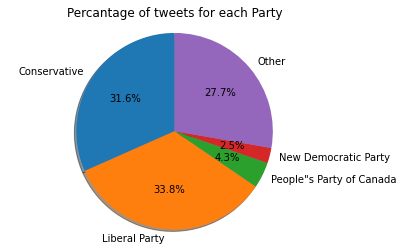

In [169]:
labels = 'Conservative', 'Liberal Party', 'People"s Party of Canada', 'New Democratic Party','Other'
sizes = [conservative_df.shape[0]/Canadian_Elections_df.shape[0], liberal_df.shape[0]/Canadian_Elections_df.shape[0], 
         ppc_df.shape[0]/Canadian_Elections_df.shape[0], ndp_df.shape[0]/Canadian_Elections_df.shape[0], other_df.shape[0]/Canadian_Elections_df.shape[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.title('Percantage of tweets for each Party')
plt.show()

In [170]:
positive_tweet_df = sentiment_analysis_df.loc[sentiment_analysis_df['label'] == 1]
negative_tweet_df = sentiment_analysis_df.loc[sentiment_analysis_df['label'] == 0]
positive_tweet_count = positive_tweet_df.shape[0]
negative_tweet_count = negative_tweet_df.shape[0]

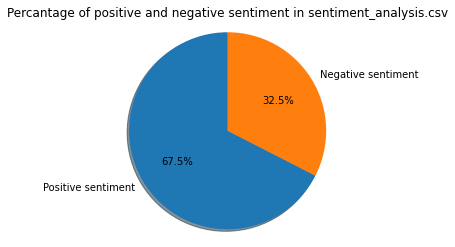

In [171]:
labels = ['Positive sentiment', 'Negative sentiment']
sizes = [positive_tweet_count, negative_tweet_count]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percantage of positive and negative sentiment in sentiment_analysis.csv')
plt.show()


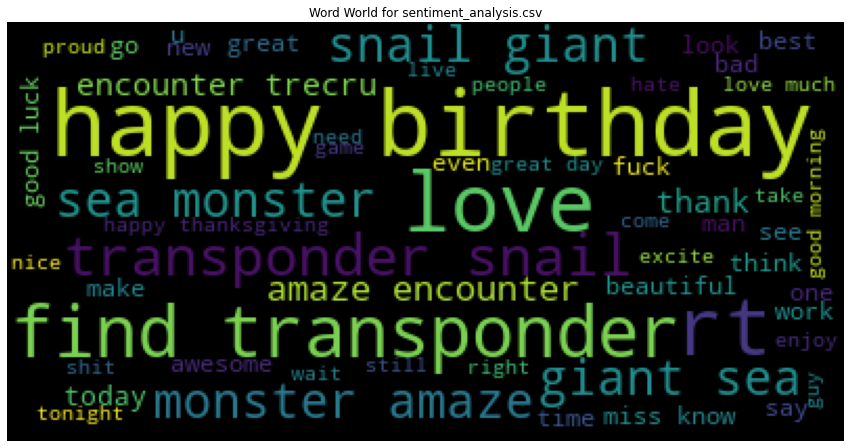

In [172]:
# Plot word world for sentiment_analysis.csv
def join_str(x):
    return " ".join(x)
single_string = sentiment_analysis_df['text'].apply(join_str)
comment_words = " ".join(single_string)
wordcloud = WordCloud(min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.title('Word World for sentiment_analysis.csv')
plt.show()

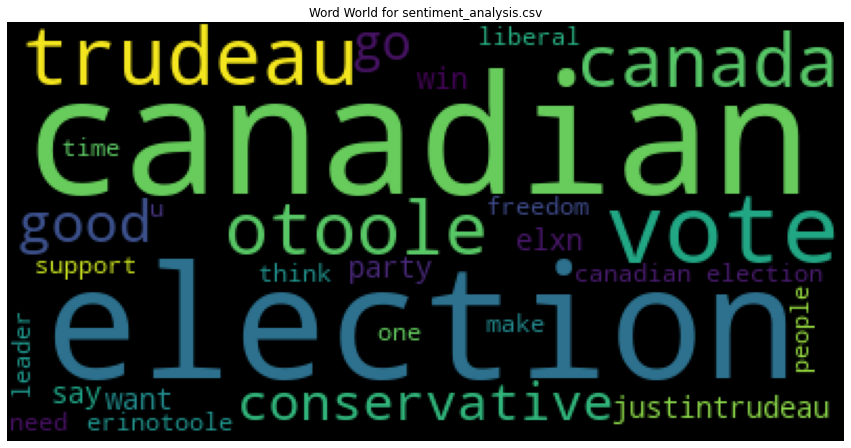

In [173]:
# Plot word world for sentiment_analysis.csv
def join_str(x):
    return " ".join(x)
single_string = Canadian_Elections_df['text'].apply(join_str)
comment_words = " ".join(single_string)
wordcloud = WordCloud(min_font_size = 10).generate(comment_words) 
plt.figure(figsize = (15, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off")
plt.title('Word World for sentiment_analysis.csv')
plt.show()

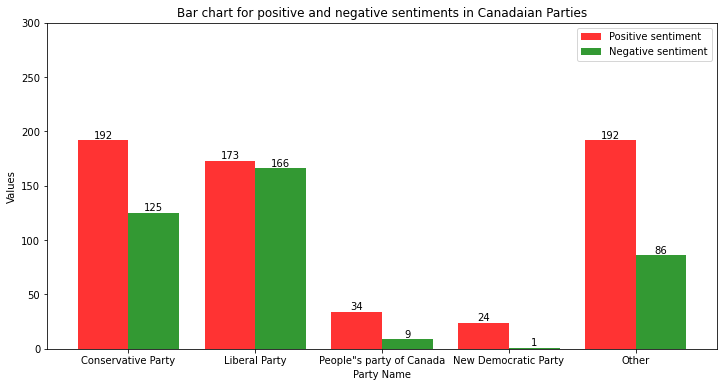

In [189]:
plt.figure(figsize=(12,6))
name = ['Conservative Party', 'Liberal Party', 'People"s party of Canada', 'New Democratic Party' ,'Other']  
positive_conservative_df = conservative_df.loc[conservative_df['sentiment'] == 1]
negative_conservative_df = conservative_df.loc[conservative_df['sentiment'] == 0]

positive_liberal_df = liberal_df.loc[liberal_df['sentiment'] == 1]
negative_liberal_df = liberal_df.loc[liberal_df['sentiment'] == 0]

positive_ppc_df = ppc_df.loc[ppc_df['sentiment'] == 1]
negative_ppc_df = ppc_df.loc[ppc_df['sentiment'] == 0]

positive_ndp_df = ndp_df.loc[ndp_df['sentiment'] == 1]
negative_ndp_df = ndp_df.loc[ndp_df['sentiment'] == 0]

positive_other_df = other_df.loc[other_df['sentiment'] == 1]
negative_other_df = other_df.loc[other_df['sentiment'] == 0]


value1 = [positive_conservative_df.shape[0], positive_liberal_df.shape[0], positive_ppc_df.shape[0], positive_ndp_df.shape[0], positive_other_df.shape[0]]
value2 = [negative_conservative_df.shape[0], negative_liberal_df.shape[0], negative_ppc_df.shape[0], negative_ndp_df.shape[0], negative_other_df.shape[0]]
x = range(5)
bar1 = plt.bar(x = [i - 0.2 for i in x], height = value1, width = 0.4,
               alpha = 0.8, color = 'r',label = 'Positive sentiment')                  

bar2 = plt.bar([i + 0.2 for i in x], value2, width = 0.4,
               alpha = 0.8,color = 'g',label = 'Negative sentiment')                  
plt.xticks(x,name)     
plt.ylim(0,300)      
plt.title('Bar chart for positive and negative sentiments in Canadaian Parties')    
plt.xlabel('Party Name')    
plt.ylabel('Values')      
plt.legend() 

def label(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '{}'.format(height),
                ha='center', va='bottom')

label(bar1)
label(bar2)
plt.show()

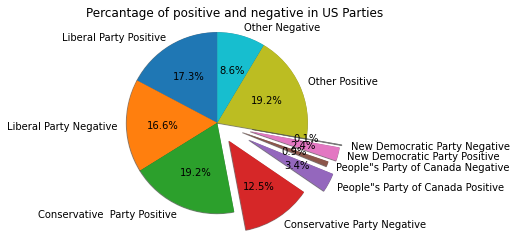

In [208]:
labels = ['Liberal Party Positive', 'Liberal Party Negative', 
          'Conservative  Party Positive', 'Conservative Party Negative',
          'People"s Party of Canada Positive', 'People"s Party of Canada Negative','New Democratic Party Positive', 'New Democratic Party Negative','Other Positive', 'Other Negative']
sizes = [positive_liberal_df.shape[0]/Canadian_Elections_df.shape[0], negative_liberal_df.shape[0]/Canadian_Elections_df.shape[0],
         positive_conservative_df.shape[0]/Canadian_Elections_df.shape[0], negative_conservative_df.shape[0]/Canadian_Elections_df.shape[0],
         positive_ppc_df.shape[0]/Canadian_Elections_df.shape[0], negative_ppc_df.shape[0]/Canadian_Elections_df.shape[0],
        positive_ndp_df.shape[0]/Canadian_Elections_df.shape[0], negative_ndp_df.shape[0]/Canadian_Elections_df.shape[0],
        positive_other_df.shape[0]/Canadian_Elections_df.shape[0], negative_other_df.shape[0]/Canadian_Elections_df.shape[0]]
explode = (0,0,0,1.2,2,1.5,1.9,2,0,0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, radius=5, explode=explode)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percantage of positive and negative in US Parties')
plt.show()

I converted each row in the text column of the sentiment analysis in order to implement the Bag of Words and TF-IDF features

In [289]:
# Transfer each row in dataframe to string
def join_str(x):
    return " ".join(x)
single_string = sentiment_analysis_df['text'].apply(join_str)


In [290]:
def bag_of_words(textdata):
    CountVec = CountVectorizer()
    Count_data = CountVec.fit_transform(textdata)
    feature_name = CountVec.get_feature_names_out()
#     cv_dataframe = pd.DataFrame(Count_data.T.toarray(), index=CountVec.get_feature_names(), columns=["Word Frequency"])
#     cv_dataframe = cv_dataframe.sort_values('Word Frequency', ascending=False)
    return Count_data


In [285]:
bag_of_words_X = bag_of_words(single_string)
bag_of_words_X

<550391x317599 sparse matrix of type '<class 'numpy.int64'>'
	with 4043986 stored elements in Compressed Sparse Row format>

In [212]:
# Calculate TF-IDF score and return them in order
def tf_idf(textdata):
    tfIdfVectorizer = TfidfVectorizer()
    tfIdf = tfIdfVectorizer.fit_transform(textdata)
#     tfIdf_df = pd.DataFrame(tfIdf[0].T.toarray(), index=tfIdfVectorizer.get_feature_names(), columns=["TF-IDF"])
#     tfIdf_df = tfIdf_df.sort_values('TF-IDF', ascending=False)
    return tfIdf

In [213]:
tfIdf_X = tf_idf(single_string)
tfIdf_X

<550391x317599 sparse matrix of type '<class 'numpy.float64'>'
	with 4043986 stored elements in Compressed Sparse Row format>

In [214]:
Y_data = sentiment_analysis_df['label']

Here I split the Data Into Training and Test for the two Features Separatelt into the 70% training Data and 30%Test Data

In [215]:
BW_x_train, BW_x_test, BW_y_train, BW_y_test = train_test_split(bag_of_words_X, Y_data, test_size = 0.30, random_state = 42)
TfIdf_x_train, TfIdf_x_test, TfIdf_y_train, TfIdf_y_test = train_test_split(tfIdf_X, Y_data, test_size = 0.30, random_state = 42)
print('Training set has shape',BW_x_train.shape, 'and test set has shape', BW_x_test.shape)
print('Training set has shape',np.array(BW_y_train).reshape(-1,1).shape, 'and test set has shape', np.array(BW_y_test).reshape(-1,1).shape)

Training set has shape (385273, 317599) and test set has shape (165118, 317599)
Training set has shape (385273, 1) and test set has shape (165118, 1)


In [216]:
warnings.filterwarnings("ignore")

In [217]:
# Grid search
def grid_serach(parameters, model, X, Y):
    parameters = parameters
    grid_obj = GridSearchCV(model, parameters, scoring='accuracy')
    grid_obj = grid_obj.fit(X, Y)
    best_hyper = grid_obj.best_params_
    best_est = grid_obj.best_estimator_
    return best_hyper, best_est

In [218]:
# Grid search for logistic regression bag of words
best_hyper_BW_LG, best_est_BW_LG = grid_serach({'C': np.arange(0,3,1)}, 
                                               LogisticRegression(), BW_x_train, BW_y_train)

In [219]:
print('Best hyparparameter for logistic regression bag of words', best_hyper_BW_LG)
print('Best model for logistic regression bag of words', best_est_BW_LG)

Best hyparparameter for logistic regression bag of words {'C': 2}
Best model for logistic regression bag of words LogisticRegression(C=2)


In [275]:
# Bag of word
model_BW_LG = best_est_BW_LG
model_BW_LG.fit(BW_x_train, BW_y_train)
prediction_BW_LG = model_BW_LG.predict(BW_x_test)
accuracy_BW_LG = accuracy_score(BW_y_test, prediction_BW_LG)

In [276]:
print ('Accuracy for Bag of word in test set using Logistic Regression:', accuracy_BW_LG)

Accuracy for Bag of word in test set using Logistic Regression: 0.9713174820431449


In [222]:
# Grid search for logistic regression TF-IDF
best_hyper_TfIdf_LG, best_est_TfIdf_LG = grid_serach({'C': np.arange(0,3,1)}, 
                                                     LogisticRegression(), TfIdf_x_train, TfIdf_y_train)

In [223]:
print('Best hyparparameter for logistic regression TF-IDF', best_hyper_TfIdf_LG)
print('Best model for logistic regression TF-IDF', best_est_TfIdf_LG)

Best hyparparameter for logistic regression TF-IDF {'C': 2}
Best model for logistic regression TF-IDF LogisticRegression(C=2)


In [224]:
model_TfIdf_LG = best_est_TfIdf_LG
model_TfIdf_LG.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_LG = model_TfIdf_LG.predict(TfIdf_x_test)
accuracy_TfIdf_LG = accuracy_score(TfIdf_y_test, prediction_TfIdf_LG)

In [225]:
print ('Accuracy for TF-IDF in test set using Logistic Regression:', accuracy_TfIdf_LG)

Accuracy for TF-IDF in test set using Logistic Regression: 0.9701243958865781


In [226]:
# Bag of word
DT_BW = DecisionTreeClassifier()
DT_BW = DT_BW.fit(BW_x_train, BW_y_train)
prediction_BW_DT = DT_BW.predict(BW_x_test)
accuracy_BW_DT = accuracy_score(BW_y_test, prediction_BW_DT)

In [227]:
print ('Accuracy for Bag of word in test set using Decision Trees:', accuracy_BW_DT)

Accuracy for Bag of word in test set using Decision Trees: 0.9484247628968374


In [230]:
# TF-IDF
DT_TfIdf = DecisionTreeClassifier()
DT_TfIdf = DT_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_DT = DT_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_DT = accuracy_score(TfIdf_y_test, prediction_TfIdf_DT)

In [231]:
print ('Accuracy for TF-IDF in test set using Decision Trees:', accuracy_TfIdf_DT)

Accuracy for TF-IDF in test set using Decision Trees: 0.9465230925762183


In [228]:
# Bag of word
knn_BW = KNeighborsClassifier()
knn_BW = knn_BW.fit(BW_x_train, BW_y_train)
prediction_BW_knn = knn_BW.predict(BW_x_test)
accuracy_BW_knn = accuracy_score(BW_y_test, prediction_BW_knn)

In [229]:
print ('Accuracy for Bag of word in test set using K-NN:', accuracy_BW_knn)

Accuracy for Bag of word in test set using K-NN: 0.9034932593660291


In [232]:
# TF-IDF
knn_TfIdf = KNeighborsClassifier()
knn_TfIdf = knn_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_knn = knn_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_knn = accuracy_score(TfIdf_y_test, prediction_TfIdf_knn)

In [233]:

print ('Accuracy for TF-IDF in test set using K-NN:', accuracy_TfIdf_knn)

Accuracy for TF-IDF in test set using K-NN: 0.5497280732567013


In [234]:

# Grid search for Naive Bayes bag of words
best_hyper_NB_BW, best_est_NB_BW = grid_serach({'alpha':np.arange(0,1,0.1)}, 
                                               MultinomialNB(), BW_x_train, BW_y_train)

In [235]:
print('Best hyparparameter for Naive Bayes bag of words', best_hyper_NB_BW)
print('Best model for Naive Bayes bag of words', best_est_NB_BW)

Best hyparparameter for Naive Bayes bag of words {'alpha': 0.9}
Best model for Naive Bayes bag of words MultinomialNB(alpha=0.9)


In [236]:
# Bag of word
NB_BW = MultinomialNB(alpha=0.9, class_prior=None, fit_prior=True)
NB_BW = NB_BW.fit(BW_x_train, BW_y_train)
prediction_BW_NB = NB_BW.predict(BW_x_test)
accuracy_BW_NB = accuracy_score(BW_y_test, prediction_BW_NB)

In [237]:

print ('Accuracy for Bag of word in test set using Naive Bayes:', accuracy_BW_NB)

Accuracy for Bag of word in test set using Naive Bayes: 0.9413207524315944


In [238]:
# Grid search for Naive Bayes TF-IDF
best_hyper_TfIdf_BW, best_est_TfIdf_BW = grid_serach({'alpha':np.arange(0,1,0.1)}, 
                                                     MultinomialNB(), TfIdf_x_train, TfIdf_y_train)

In [239]:
print('Best hyparparameter for Naive Bayes TF-IDF', best_hyper_TfIdf_BW)
print('Best model for Naive Bayes TF-IDF', best_est_TfIdf_BW)

Best hyparparameter for Naive Bayes TF-IDF {'alpha': 0.2}
Best model for Naive Bayes TF-IDF MultinomialNB(alpha=0.2)


In [240]:
# TF-IDF
NB_TfIdf = MultinomialNB(alpha=0.3, class_prior=None, fit_prior=True)
NB_TfIdf = NB_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_NB = NB_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_NB = accuracy_score(TfIdf_y_test, prediction_TfIdf_NB)

In [241]:
print ('Accuracy for TF-IDF in test set using Naive Bayes:', accuracy_TfIdf_NB)

Accuracy for TF-IDF in test set using Naive Bayes: 0.9165687568890127


In [242]:
# Grid search for SVM bag of words
best_hyper_SVM_BW, best_est_SVM_BW = grid_serach({'penalty': ['l1', 'l2'], 'loss':['hinge', 'squared_hinge']}, 
                                                   LinearSVC(), BW_x_train, BW_y_train)

In [243]:
print('Best hyparparameter for SVM bag of words', best_hyper_SVM_BW)
print('Best model for SVM bag of words', best_est_SVM_BW)

Best hyparparameter for SVM bag of words {'loss': 'hinge', 'penalty': 'l2'}
Best model for SVM bag of words LinearSVC(loss='hinge')


In [244]:
# Bag of word
SVM_BW = LinearSVC(C=1.0, loss='hinge', penalty='l2')
SVM_BW = SVM_BW.fit(BW_x_train, BW_y_train)
prediction_BW_SVM = SVM_BW.predict(BW_x_test)
accuracy_BW_SVM = accuracy_score(BW_y_test, prediction_BW_SVM)

In [245]:
print ('Accuracy for Bag of word in test set using SVM:', accuracy_BW_SVM)

Accuracy for Bag of word in test set using SVM: 0.9699911578386367


In [246]:
# Grid search for SVM TF-IDF
best_hyper_SVM_TfIdf, best_est_SVM_TfIdf = grid_serach({'penalty': ['l1', 'l2'], 'loss':['hinge', 'squared_hinge']}, 
                                                   LinearSVC(), TfIdf_x_train, TfIdf_y_train)

In [247]:
print('Best hyparparameter for SVM TF-IDF', best_hyper_SVM_TfIdf)
print('Best model for SVM TF-IDF', best_est_SVM_TfIdf)

Best hyparparameter for SVM TF-IDF {'loss': 'hinge', 'penalty': 'l2'}
Best model for SVM TF-IDF LinearSVC(loss='hinge')


In [249]:
# TF-IDF
SVM_TfIdf = LinearSVC(C=1.0, loss='hinge', penalty='l2')
SVM_TfIdf = SVM_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_SVM = SVM_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_SVM = accuracy_score(TfIdf_y_test, prediction_TfIdf_SVM)

In [250]:
print ('Accuracy for TF-IDF in test set using SVM:', accuracy_TfIdf_SVM)

Accuracy for TF-IDF in test set using SVM: 0.9707966424011919


In [251]:
# Bag of word
RF_BW = RandomForestClassifier(n_estimators=10)
RF_BW = RF_BW.fit(BW_x_train, BW_y_train)
prediction_BW_RF = RF_BW.predict(BW_x_test)
accuracy_BW_RF = accuracy_score(BW_y_test, prediction_BW_RF)

In [252]:
print ('Accuracy for Bag of word in test set using Random Forest:', accuracy_BW_RF)

Accuracy for Bag of word in test set using Random Forest: 0.9484005377972117


In [253]:
# TF-IDF
RF_TfIdf = RandomForestClassifier(n_estimators=10)
RF_TfIdf = RF_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_RF = RF_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_RF = accuracy_score(TfIdf_y_test, prediction_TfIdf_RF)

In [254]:
print ('Accuracy for TF-IDF in test set using Random Forest:', accuracy_TfIdf_RF)

Accuracy for TF-IDF in test set using Random Forest: 0.9499570004481643


In [255]:
XGB_BW = xgb.XGBClassifier()
XGB_BW = XGB_BW.fit(BW_x_train, BW_y_train)
prediction_BW_XGB = XGB_BW.predict(BW_x_test)
accuracy_BW_XGB = accuracy_score(BW_y_test, prediction_BW_XGB)

[18:48:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [256]:
print ('Accuracy for Bag of word in test set using XGBoost:', accuracy_BW_XGB)

Accuracy for Bag of word in test set using XGBoost: 0.9308252280187502


In [257]:
XGB_TfIdf = xgb.XGBClassifier()
XGB_TfIdf = XGB_TfIdf.fit(TfIdf_x_train, TfIdf_y_train)
prediction_TfIdf_XGB = XGB_TfIdf.predict(TfIdf_x_test)
accuracy_TfIdf_XGB = accuracy_score(TfIdf_y_test, prediction_TfIdf_XGB)

[18:49:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [258]:
print ('Accuracy for TF-IDF in test set using XGBoost:', accuracy_TfIdf_XGB)

Accuracy for TF-IDF in test set using XGBoost: 0.9302014317033879


In [292]:
single_string_Canada = Canadian_Elections_df['text'].apply(join_str)
CountVec = CountVectorizer()
CountVec.fit(single_string)
Count_data_Canada = CountVec.transform(single_string_Canada)
feature_name = CountVec.get_feature_names()
Count_data_Canada

<1002x317599 sparse matrix of type '<class 'numpy.int64'>'
	with 14129 stored elements in Compressed Sparse Row format>

In [293]:
y_Canada = Canadian_Elections_df['sentiment']
model_BW_LG = best_est_BW_LG
model_BW_LG.fit(BW_x_train, BW_y_train)


LogisticRegression(C=2)

In [295]:
prediction_Canada = model_BW_LG.predict(Count_data_Canada)
accuracy_Canada = accuracy_score(y_Canada, prediction_Canada)
print('The best performance on the 2021 Canada Elections data has accuracy', accuracy_Canada)

The best performance on the 2021 Canada Elections data has accuracy 0.6986027944111777


In [297]:
Canadian_Elections_df['predict'] = prediction_Canada

In [298]:
# Original positive for Liberal 
pos_org_lib = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 1][Canadian_Elections_df['party'] == 'Liberal'].shape[0]
# Original negative for Liberal 
neg_org_lib = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 0][Canadian_Elections_df['party'] == 'Liberal'].shape[0]
# Predict positive for Liberal 
pos_pred_lib = Canadian_Elections_df.loc[Canadian_Elections_df['predict'] == 1][Canadian_Elections_df['party'] == 'Liberal'].shape[0]
# Predict negative for Democratic 
neg_pred_lib = Canadian_Elections_df.loc[Canadian_Elections_df['predict'] == 0][Canadian_Elections_df['party'] == 'Liberal'].shape[0]

# Original postive for Republican
pos_org_con = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 1][Canadian_Elections_df['party'] == 'Conservative'].shape[0]
# Original negative for Republican
neg_org_con = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 0][Canadian_Elections_df['party'] == 'Conservative'].shape[0]
# Predict positive for Republican 
pos_pred_con = Canadian_Elections_df.loc[Canadian_Elections_df['predict'] == 1][Canadian_Elections_df['party'] == 'Conservative'].shape[0]
# Predict negative for Republican 
neg_pred_con = Canadian_Elections_df.loc[Canadian_Elections_df['predict'] == 0][Canadian_Elections_df['party'] == 'Conservative'].shape[0]

# Original positive for Democratic 
pos_org_ndp = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 1][Canadian_Elections_df['party'] == 'NDP'].shape[0]
# Original negative for Democratic 
neg_org_ndp = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 0][Canadian_Elections_df['party'] == 'NDP'].shape[0]
# Predict positive for Democratic 
pos_pred_ndp = Canadian_Elections_df.loc[Canadian_Elections_df['predict'] == 1][Canadian_Elections_df['party'] == 'NDP'].shape[0]
# Predict negative for Democratic 
neg_pred_ndp = Canadian_Elections_df.loc[Canadian_Elections_df['predict'] == 0][Canadian_Elections_df['party'] == 'NDP'].shape[0]

# Original postive for Republican
pos_org_ppc = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 1][Canadian_Elections_df['party'] == 'PPC'].shape[0]
# Original negative for Republican
neg_org_ppc = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 0][Canadian_Elections_df['party'] == 'PPC'].shape[0]
# Predict positive for Republican 
pos_pred_ppc = Canadian_Elections_df.loc[Canadian_Elections_df['predict'] == 1][Canadian_Elections_df['party'] == 'PPC'].shape[0]
# Predict negative for Republican 
neg_pred_ppc = Canadian_Elections_df.loc[Canadian_Elections_df['predict'] == 0][Canadian_Elections_df['party'] == 'PPC'].shape[0]

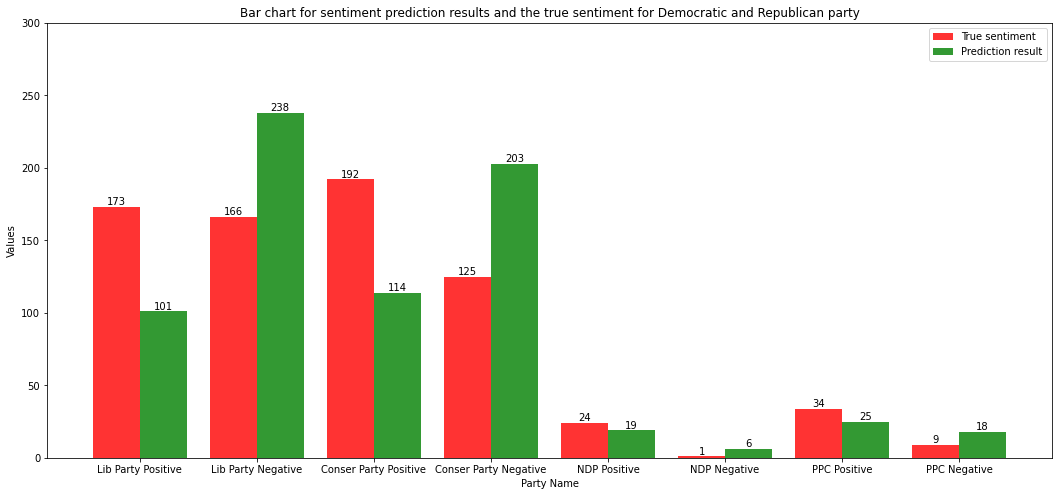

In [301]:
plt.figure(figsize=(18,8))
name = ['Lib Party Positive', 'Lib Party Negative', 'Conser Party Positive', 'Conser Party Negative', 'NDP Positive', 'NDP Negative', 'PPC Positive', 'PPC Negative']  

value1 = [pos_org_lib, neg_org_lib, pos_org_con, neg_org_con, pos_org_ndp, neg_org_ndp, pos_org_ppc, neg_org_ppc]
value2 = [pos_pred_lib, neg_pred_lib, pos_pred_con, neg_pred_con, pos_pred_ndp, neg_pred_ndp, pos_pred_ppc, neg_pred_ppc]

X = np.arange(8) 
bar1 = plt.bar(x = [i - 0.2 for i in X], height=value1, width=0.4,
               alpha=0.8, color='r',label ='True sentiment')                  

bar2 = plt.bar([i + 0.2 for i in X], height=value2, width = 0.4,
               alpha=0.8,color ='g', label ='Prediction result')  
 
plt.xticks(X, name)     
plt.ylim(0,300)     
plt.title('Bar chart for sentiment prediction results and the true sentiment for Democratic and Republican party')    
plt.xlabel('Party Name')    
plt.ylabel('Values')      
plt.legend()

def label(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                '{}'.format(height),
                ha='center', va='bottom')

label(bar1)
label(bar2)
plt.show()


In [347]:

neg_Canada_df = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 0]
print('Numner of Null in negative_reason column is', neg_Canada_df['negative_reason'].isnull().sum())

Numner of Null in negative_reason column is 0


In [348]:
reason_list = neg_Canada_df['negative_reason'].unique()
reason_list

array(['calling election early', 'covid ', 'others', 'scandal',
       'tell lies', 'gun control', 'economy', 'healthcare and marijuana',
       'segregation', 'women reproductive right and racism',
       'climate problem'], dtype=object)

In [349]:
reason_encode = {
    'calling election early':0,
    'covid ':1, 
    'others':2, 
    'scandal':3, 
    'tell lies':4,
    'gun control':5,
    'economy':6, 
    'healthcare and marijuana':7, 
    'segregation':8, 
    'climate problem':9,
    'women reproductive right and racism':10
}

In [350]:
neg_Canada_df['negative_reason'] = neg_Canada_df['negative_reason'].map(reason_encode)
neg_Canada_df

,text,sentiment,negative_reason,party,predict
0,"[canadian, election, power, grab, pm, trudeau,...",0,0,Liberal,1
1,"[hope, trudeau, lose, canadian, election, tomo...",0,1,Liberal,0
3,"[canadian, friend, never, forget, trudeau, yea...",0,0,Liberal,0
5,"[vaccine, gun, key, election, toole, serious, ...",0,1,Conservative,0
6,"[im, sorry, moderator, respond, leadership, ca...",0,2,Other,0
...,...,...,...,...,...
997,"[absolutely, horrible, canada, forthcoming, el...",0,2,Other,0
998,"[davidakin, trudeau, impose, gun, control, pol...",0,5,Conservative,0
999,"[canada, election, steal, thug, uneducated, go...",0,2,Other,0
1000,"[toole, amend, platform, gun, control, questio...",0,4,Conservative,0


In [351]:
neg_Canada_string = neg_Canada_df['text'].apply(join_str)
BoW_neg_X = bag_of_words(neg_Canada_string)
BoW_neg_X

<387x2054 sparse matrix of type '<class 'numpy.int64'>'
	with 6365 stored elements in Compressed Sparse Row format>

In [352]:
TfIdf_neg_X = tf_idf(neg_Canada_string)
TfIdf_neg_X

<387x2054 sparse matrix of type '<class 'numpy.float64'>'
	with 6365 stored elements in Compressed Sparse Row format>

In [353]:
y_Canada = neg_Canada_df['negative_reason']
# Bag of words
BoW_neg_x_train, BoW_neg_x_test, BoW_neg_y_train, BoW_neg_y_test = train_test_split(BoW_neg_X, y_Canada, test_size = 0.30, random_state = 42)
# TF-IDF
TfIdf_neg_x_train, TfIdf_neg_x_test, TfIdf_neg_y_train, TfIdf_neg_y_test = train_test_split(TfIdf_neg_X, y_Canada, test_size = 0.30, random_state = 42)

In [354]:
# Bag of words
best_hyper_LRBoW, best_est_LRBoW = grid_serach({'C': np.arange(0, 3, 0.5), 
              'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'saga']},
               LogisticRegression(), BoW_neg_x_train, BoW_neg_y_train)

In [355]:
best_est_LRBoW

LogisticRegression(C=0.5)

In [356]:
LRBoW_model = best_est_LRBoW
kfold = KFold(n_splits=5)
accuracy_LRBoW_model_train = cross_val_score(LRBoW_model, BoW_neg_x_train, BoW_neg_y_train, cv=kfold)
print('Train accuracy for Logistic Regression bag of words', np.mean(accuracy_LRBoW_model_train))
# LRBoW_model = LRBoW_model.fit(BoW_neg_x_train, BoW_neg_y_train)
# prediction_LRBoW_model_test = LRBoW_model.predict(BoW_neg_x_test)
# accuracy_LRBoW_model_test = accuracy_score(BoW_neg_y_test, prediction_LRBoW_model_test)
# print('Test accuracy for Logistic Regression bag of words', accuracy_LRBoW_model_test)


Train accuracy for Logistic Regression bag of words 0.47037037037037044


In [357]:
# TF-IDF
best_hyper_LRTfIdf, best_est_LRTfIdf = grid_serach({'C': np.arange(0, 3, 0.5), 
              'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'saga']}, 
              LogisticRegression(), TfIdf_neg_x_train, TfIdf_neg_y_train)

In [358]:

best_est_LRTfIdf

LogisticRegression(C=2.5, penalty='l1', solver='saga')

In [359]:

LRTfIdf_model = best_est_LRTfIdf
kfold = KFold(n_splits=5)
accuracy_LRTfIdf_model_train = cross_val_score(LRTfIdf_model, TfIdf_neg_x_train, TfIdf_neg_y_train, cv=kfold)
print('Train accuracy for Logistic Regression TF-IDF', np.mean(accuracy_LRTfIdf_model_train))

# LRTfIdf_model = LRTfIdf_model.fit(TfIdf_neg_x_train, TfIdf_neg_y_train)
# prediction_LRTfIdf_model_test = LRTfIdf_model.predict(TfIdf_neg_x_test)
# accuracy_LRTfIdf_model_test = accuracy_score(TfIdf_neg_y_test, prediction_LRTfIdf_model_test)
# print('Accuracy for Logistic Regression TF-IDF', accuracy_LRTfIdf_model_test)

Train accuracy for Logistic Regression TF-IDF 0.4851851851851851


In [360]:

# Bag of words
best_hyper_SVMBoW, best_est_SVMBoW = grid_serach({'penalty': ['l1','l2'], 'loss': ['hinge','squared_hinge'],
                                               'C':np.arange(0, 3, 0.5)}, 
                                                LinearSVC(), BoW_neg_x_train, BoW_neg_y_train)

In [361]:
best_est_SVMBoW

LinearSVC(C=0.5)

In [362]:
SVMBoW_model = best_est_SVMBoW
kfold = KFold(n_splits=5)
accuracy_SVMBoW_model_train = cross_val_score(SVMBoW_model, BoW_neg_x_train, BoW_neg_y_train, cv=kfold)
SVMBoW_model = SVMBoW_model.fit(BoW_neg_x_train, BoW_neg_y_train)
print('Train accuracy for SVM bag of words', np.mean(accuracy_SVMBoW_model_train))

# SVMBoW_model = SVMBoW_model.fit(BoW_neg_x_train, BoW_neg_y_train)                                           
# prediction_SVMBoW_model_test = SVMBoW_model.predict(BoW_neg_x_test)
# accuracy_SVMBoW_model_test = accuracy_score(BoW_neg_y_test, prediction_SVMBoW_model_test)
# print('Accuracy for SVM bag of words', accuracy_SVMBoW_model_test)

Train accuracy for SVM bag of words 0.46296296296296297


In [363]:
# TF-IDF
best_hyper_SVMTfIdf, best_est_SVMTfIdf = grid_serach({'penalty': ['l1','l2'], 'loss': ['hinge','squared_hinge'],
                                               'C':np.arange(0, 3, 0.5)}, 
                                                LinearSVC(), TfIdf_neg_x_train, TfIdf_neg_y_train)

In [364]:
best_est_SVMTfIdf

LinearSVC(C=0.5)

In [365]:
SVMTfIdf_model = best_est_SVMTfIdf
kfold = KFold(n_splits=5)
accuracy_SVMTfIdf_model_train = cross_val_score(SVMTfIdf_model, TfIdf_neg_x_train, TfIdf_neg_y_train, cv=kfold)
print('Train accuracy for SVM TF-IDF', np.mean(accuracy_SVMTfIdf_model_train))
# prediction_SVMTfIdf_model_train = SVMTfIdf_model.predict(TfIdf_neg_x_train)
# accuracy_SVMTfIdf_model_train = accuracy_score(TfIdf_neg_y_train, prediction_SVMTfIdf_model_train)

# SVMTfIdf_model = SVMTfIdf_model.fit(TfIdf_neg_x_train, TfIdf_neg_y_train)
# prediction_SVMTfIdf_model_test = SVMTfIdf_model.predict(TfIdf_neg_x_test)
# accuracy_SVMTfIdf_model_test = accuracy_score(TfIdf_neg_y_test, prediction_SVMTfIdf_model_test)
# print('Test accuracy for SVM TF-IDF', accuracy_SVMTfIdf_model_test)

Train accuracy for SVM TF-IDF 0.4703703703703703


In [366]:
# Bag of words
best_hyper_NBBoW, best_est_NBBoW = grid_serach({'alpha':np.arange(0,2,0.1)}, 
                                                MultinomialNB(), BoW_neg_x_train, BoW_neg_y_train)

In [367]:
best_est_NBBoW

MultinomialNB(alpha=1.9000000000000001)

In [368]:
NBBoW_model = best_est_NBBoW
kfold = KFold(n_splits=5)
accuracy_NBBoW_model_train = cross_val_score(NBBoW_model, BoW_neg_x_train, BoW_neg_y_train, cv=kfold)
print('Train accuracy for Naive Byaes bag of words', np.mean(accuracy_NBBoW_model_train))

# NBBoW_model = NBBoW_model.fit(BoW_neg_x_train, BoW_neg_y_train)
# prediction_NBBoW_model_test = NBBoW_model.predict(BoW_neg_x_test)
# accuracy_NBBoW_model_test = accuracy_score(BoW_neg_y_test, prediction_NBBoW_model_test)
# print('Test accuracy for Naive Byaes bag of words', accuracy_NBBoW_model_test)

Train accuracy for Naive Byaes bag of words 0.4666666666666666


In [369]:
# TF-IDF
best_hyper_NBTfIdf, best_est_NBTfIdf = grid_serach({'alpha':np.arange(0,2,0.1)}, 
                                                MultinomialNB(), TfIdf_neg_x_train, TfIdf_neg_y_train)

In [370]:
best_est_NBTfIdf

MultinomialNB(alpha=0.30000000000000004)

In [371]:
NBTfIdf_model = best_est_NBTfIdf
kfold = KFold(n_splits=5)
accuracy_NBTfIdf_model_train = cross_val_score(NBTfIdf_model, TfIdf_neg_x_train, TfIdf_neg_y_train, cv=kfold)
print('Train accuracy for Naive Byaes TF-IDF', np.mean(accuracy_NBTfIdf_model_train))

# NBTfIdf_model = NBTfIdf_model.fit(TfIdf_neg_x_train, TfIdf_neg_y_train)
# prediction_NBTfIdf_model_test = NBTfIdf_model.predict(TfIdf_neg_x_test)
# accuracy_NBTfIdf_model_test = accuracy_score(TfIdf_neg_y_test, prediction_NBTfIdf_model_test)
# print('Test accuracy for Naive Byaes TF-IDF', accuracy_NBTfIdf_model_test)

Train accuracy for Naive Byaes TF-IDF 0.45925925925925926


In [372]:

#LRTfIdf_model = best_est_LRTfIdf
#prediction_LRTfIdf_model_test = LRTfIdf_model.predict(TfIdf_neg_x_test)

# LRTfIdf_model = LRTfIdf_model.fit(TfIdf_neg_x_train, TfIdf_neg_y_train)
prediction_LRTfIdf_model_test = LRTfIdf_model.predict(TfIdf_neg_x_test)
accuracy_LRTfIdf_model_test = accuracy_score(TfIdf_neg_y_test, prediction_LRTfIdf_model_test)
print('Accuracy for Logistic Regression TF-IDF', accuracy_LRTfIdf_model_test)

Accuracy for Logistic Regression TF-IDF 0.5299145299145299


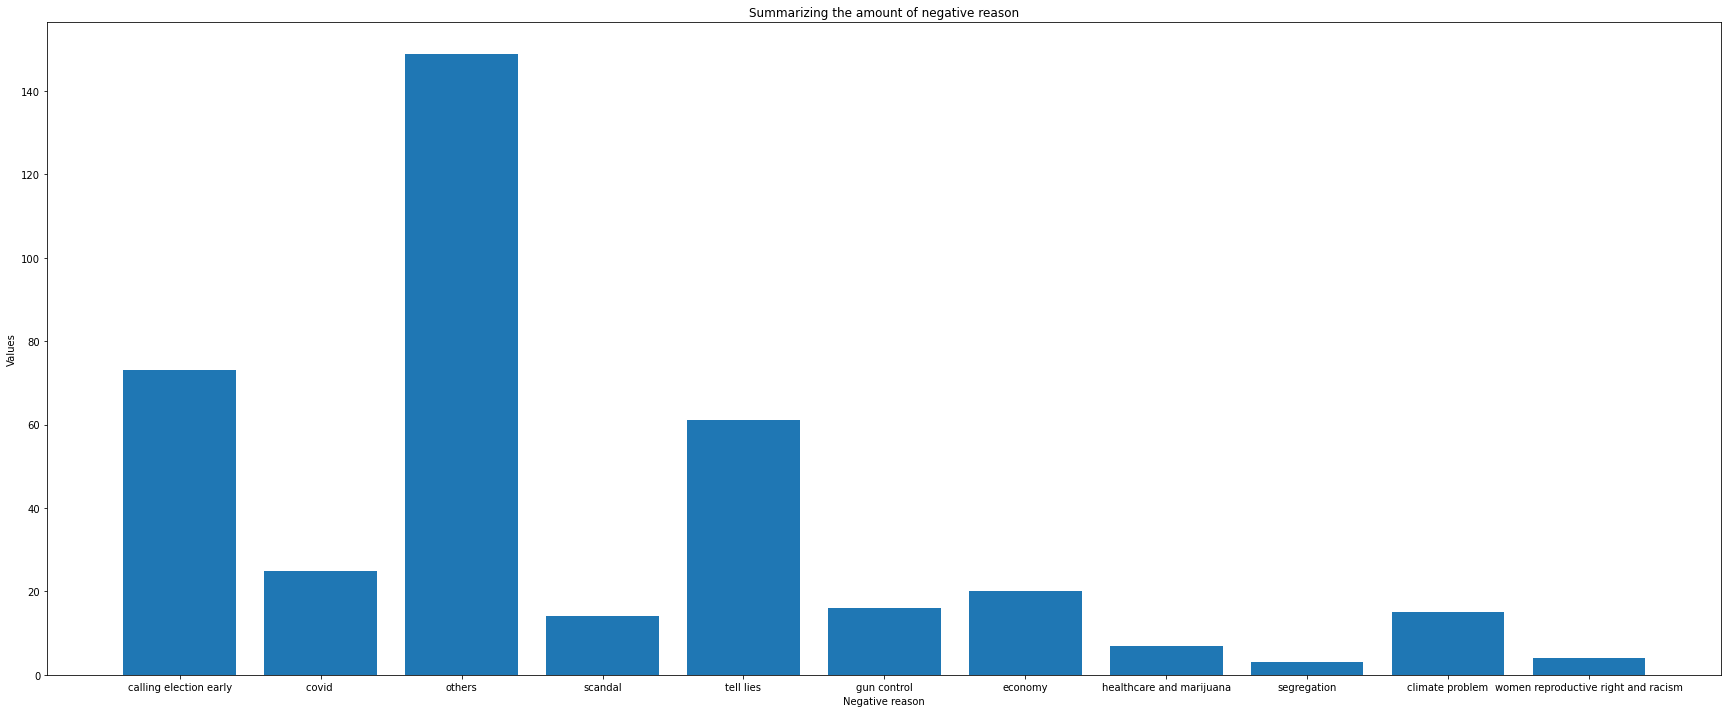

In [387]:
# Number of negative reason on whole data set include training and test
reason0 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 0].shape[0]
reason1 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 1].shape[0]
reason2 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 2].shape[0]
reason3 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 3].shape[0]
reason4 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 4].shape[0]
reason5 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 5].shape[0]
reason6 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 6].shape[0]
reason7 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 7].shape[0]
reason8 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 8].shape[0]
reason9 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 9].shape[0]
reason10 = neg_Canada_df.loc[neg_Canada_df['negative_reason'] == 10].shape[0]

fig = plt.figure(figsize=(30,12))
langs = ['calling election early', 'covid ', 'others', 'scandal',
       'tell lies', 'gun control', 'economy', 'healthcare and marijuana',
       'segregation','climate problem','women reproductive right and racism']  
reasons = [reason0, reason1, reason2, reason3, reason4, reason5, reason6, reason7, reason8,reason9, reason10]
plt.bar(langs,reasons)
plt.title('Summarizing the amount of negative reason')    
plt.xlabel('Negative reason')    
plt.ylabel('Values')
plt.show()


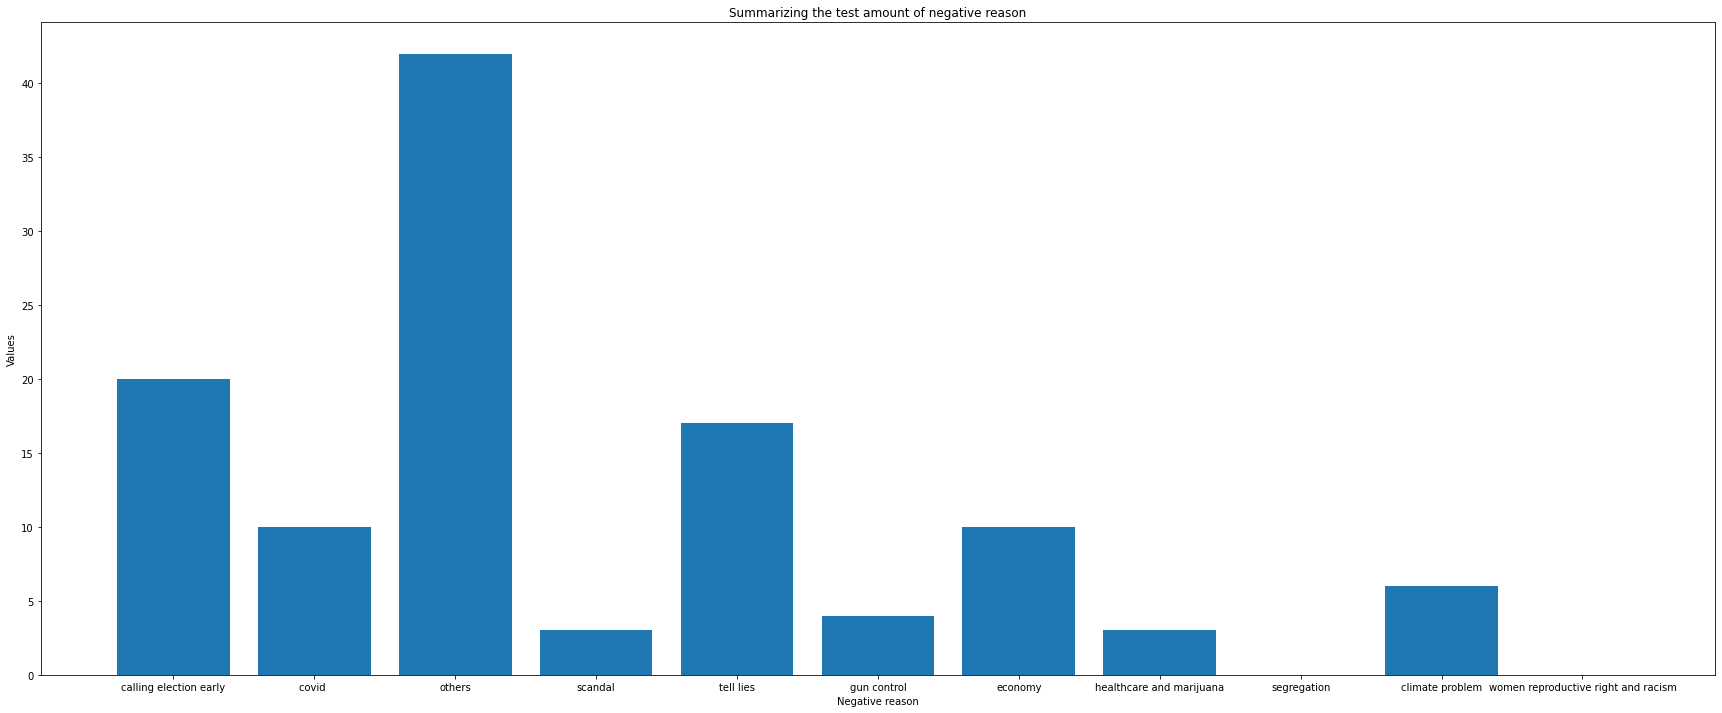

In [388]:
# Number of negative reason on test set
TfIdf_neg_test_df = pd.DataFrame(TfIdf_neg_x_test, columns=['TF-IDF Test X'])
TfIdf_neg_test_df['TF-IDF Test Y'] = np.array(TfIdf_neg_y_test)

reason0_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 0].shape[0]
reason1_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 1].shape[0]
reason2_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 2].shape[0]
reason3_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 3].shape[0]
reason4_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 4].shape[0]
reason5_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 5].shape[0]
reason6_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 6].shape[0]
reason7_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 7].shape[0]
reason8_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 8].shape[0]
reason9_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] == 9].shape[0]
reason10_test = TfIdf_neg_test_df.loc[TfIdf_neg_test_df['TF-IDF Test Y'] ==104].shape[0]

fig = plt.figure(figsize=(30,12))
langs = ['calling election early', 'covid ', 'others', 'scandal',
       'tell lies', 'gun control', 'economy', 'healthcare and marijuana',
       'segregation','climate problem','women reproductive right and racism']  
reasons = [reason0_test, reason1_test, reason2_test, reason3_test, reason4_test, reason5_test, reason6_test, reason7_test, reason8_test, reason9_test, reason10_test]
plt.bar(langs,reasons)
plt.title('Summarizing the test amount of negative reason')    
plt.xlabel('Negative reason')    
plt.ylabel('Values')
plt.show()

In [389]:
reason0_pred = (prediction_LRTfIdf_model_test == 0).sum()
reason1_pred = (prediction_LRTfIdf_model_test == 1).sum()
reason2_pred = (prediction_LRTfIdf_model_test == 2).sum()
reason3_pred = (prediction_LRTfIdf_model_test == 3).sum()
reason4_pred = (prediction_LRTfIdf_model_test == 4).sum()
reason5_pred = (prediction_LRTfIdf_model_test == 5).sum()
reason6_pred = (prediction_LRTfIdf_model_test == 6).sum()
reason7_pred = (prediction_LRTfIdf_model_test == 7).sum()
reason8_pred = (prediction_LRTfIdf_model_test == 8).sum()
reason9_pred = (prediction_LRTfIdf_model_test == 9).sum()
reason10_pred = (prediction_LRTfIdf_model_test == 10).sum()


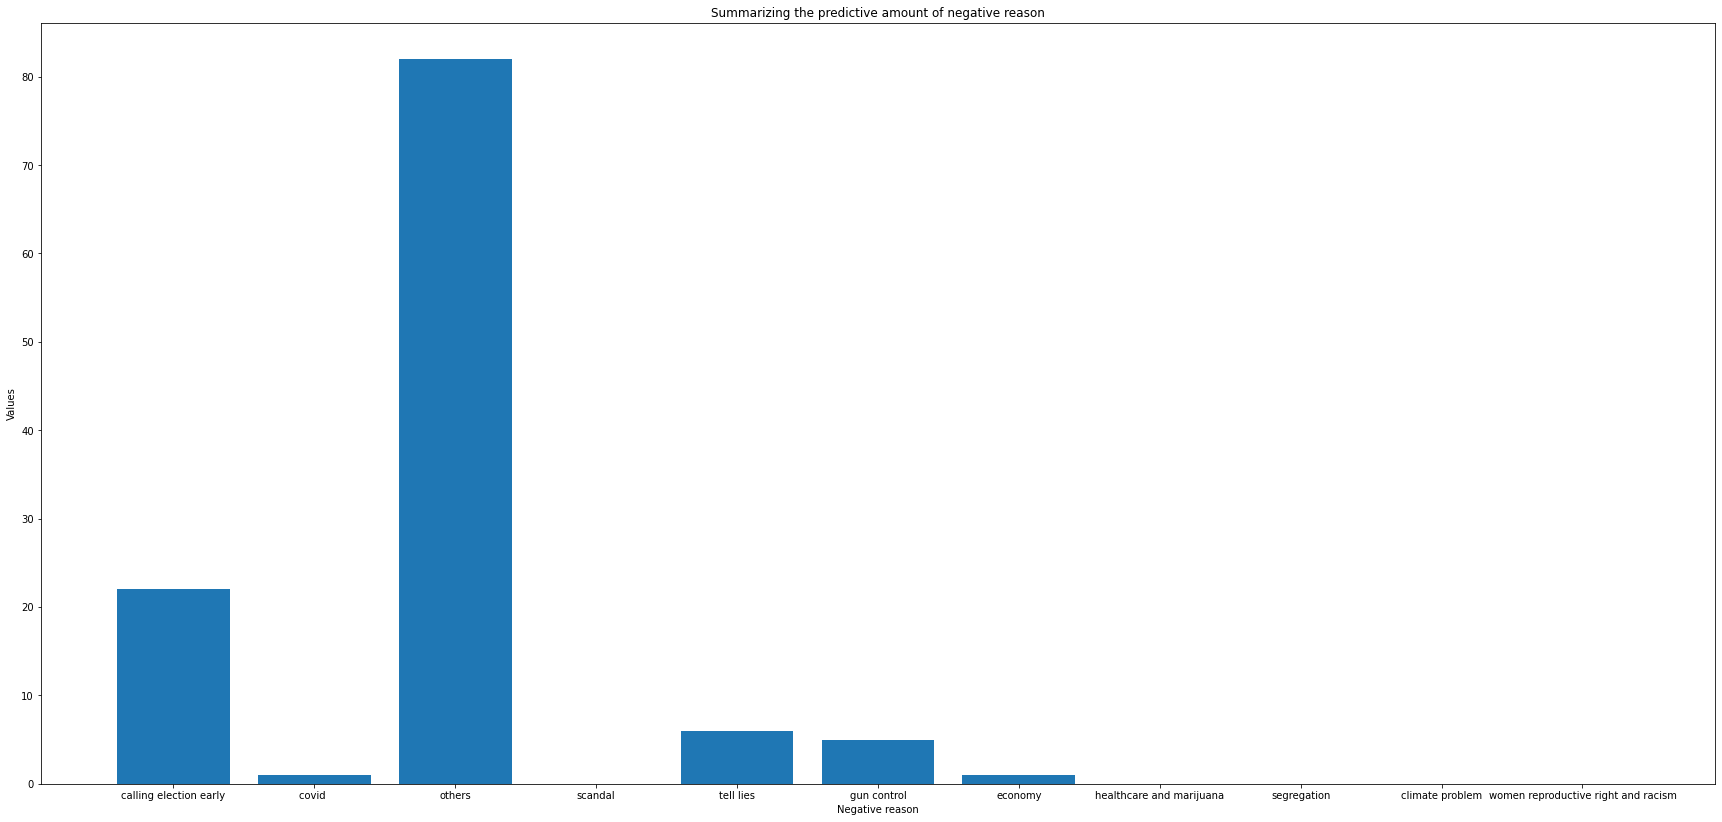

In [390]:
fig = plt.figure(figsize=(30,14))
langs = ['calling election early', 'covid ', 'others', 'scandal',
       'tell lies', 'gun control', 'economy', 'healthcare and marijuana',
       'segregation','climate problem','women reproductive right and racism']  
reasons = [reason0_pred, reason1_pred, reason2_pred, reason3_pred, reason4_pred, reason5_pred, reason6_pred, reason7_pred, reason8_pred, reason9_pred, reason10_pred]
plt.bar(langs,reasons)
plt.title('Summarizing the predictive amount of negative reason')    
plt.xlabel('Negative reason')    
plt.ylabel('Values')
plt.show()

In [373]:
def get_top_n_words(corpus, n=None):

    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [375]:
# Transfer each row in dataframe to string
def join_str(x):
    return " ".join(x)
single_string_neg = neg_Canada_df['text'].apply(join_str)

In [377]:
single_string_neg

0       canadian election power grab pm trudeau yes ta...
1       hope trudeau lose canadian election tomorrow c...
3       canadian friend never forget trudeau year mand...
5       vaccine gun key election toole serious plan ge...
6       im sorry moderator respond leadership candidat...
                              ...                        
997     absolutely horrible canada forthcoming electio...
998     davidakin trudeau impose gun control policy ut...
999     canada election steal thug uneducated goon dem...
1000    toole amend platform gun control question rema...
1001    justintrudeau stop lie stop manipulation stop ...
Name: text, Length: 387, dtype: object

In [378]:
common_words = get_top_n_words(single_string_neg, 50)
for word, freq in common_words:
    print(word, freq)

election 272
canadian 211
trudeau 156
otoole 98
canada 78
call 72
vote 63
pandemic 51
justintrudeau 47
elxn 46
like 45
say 44
conservative 42
get 40
liberal 40
party 39
cdnpoli 36
want 35
year 33
go 32
win 32
gun 31
nevervoteconservative 30
care 30
think 29
erinotoole 28
lie 28
good 28
bad 27
pm 26
people 26
see 26
leader 24
one 24
toole 24
never 23
justin 23
covid 22
million 22
know 21
would 21
take 20
country 20
erin 20
day 20
promise 20
many 19
con 19
make 18
government 18


In [379]:
pos_Canada_df = Canadian_Elections_df.loc[Canadian_Elections_df['sentiment'] == 1]

In [380]:
single_string_pos = pos_Canada_df['text'].apply(join_str)

In [381]:
common_words = get_top_n_words(single_string_pos, 50)
for word, freq in common_words:
    print(word, freq)

election 428
canadian 320
vote 269
trudeau 176
otoole 146
canada 143
good 112
party 93
win 90
get 87
elxn 75
liberal 67
conservative 60
federal 59
go 58
like 55
freedom 53
ppc 52
cdnpoli 50
day 50
support 49
need 48
voteppc 47
want 47
make 47
leader 45
best 44
right 43
ndp 43
time 43
justintrudeau 43
erinotoole 42
people 42
love 40
great 39
would 38
thank 38
think 38
say 37
hope 36
let 35
justin 35
cpc 34
one 33
call 32
debate 30
voteliberal 29
please 28
know 27
care 27
